### 1. Feature Extraction with ResNet50

This cell extracts feature vectors from clothing images using a pre-trained ResNet50 model.  
Each image in the `Resimler1` directory is resized, normalized, and processed to obtain a 2048-dimensional feature vector.  
The results are stored in a dictionary (`features_dict`) and saved as `item_features.npy` for later use in the recommendation system.


In [2]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
import numpy as np
from tqdm import tqdm

base_folder = r"C:\Users\semer\Desktop\Resimler1"

model = resnet50(pretrained=True)
model.eval()
model = torch.nn.Sequential(*list(model.children())[:-1])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

features_dict = {}

for outfit_id in os.listdir(base_folder):
    outfit_path = os.path.join(base_folder, outfit_id)
    if not os.path.isdir(outfit_path):
        continue

    for img_name in tqdm(os.listdir(outfit_path), desc=f"⏳ {outfit_id}"):
        if not img_name.endswith(".jpg"):
            continue

        item_id = img_name.split(".")[0]
        img_path = os.path.join(outfit_path, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0)

            with torch.no_grad():
                output = model(image_tensor).squeeze().numpy()

            features_dict[item_id] = output

        except Exception as e:
            print(f"⚠️ Hata ({item_id}): {e}")

np.save("item_features.npy", features_dict)
print(f"✅ {len(features_dict)} item için özellik çıkarıldı ve 'item_features.npy' olarak kaydedildi.")


C:\Users\semer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\semer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

























































































































































































































































































































✅ 3423 item için özellik çıkarıldı ve 'item_features.npy' olarak kaydedildi.


### 2. Building the Initial Graph Network

This section constructs the base graph structure.  
Each outfit is added as a node, and all item images within that outfit are connected as separate nodes with their associated feature vectors.  
Edges are created between the outfit node and each of its item nodes.


In [3]:
import os
import networkx as nx
import numpy as np

base_folder = r"C:\Users\semer\Desktop\Resimler1"
feature_path = "item_features.npy"

features_dict = np.load(feature_path, allow_pickle=True).item()
G = nx.Graph()

for outfit_id in os.listdir(base_folder):
    outfit_path = os.path.join(base_folder, outfit_id)
    if not os.path.isdir(outfit_path):
        continue

    G.add_node(outfit_id, type="outfit")

    for img_name in os.listdir(outfit_path):
        if not img_name.endswith(".jpg"):
            continue

        item_id = img_name.split(".")[0]
        G.add_node(item_id, type="item", feature=features_dict.get(item_id))
        G.add_edge(outfit_id, item_id)

print(f"✅ Graph oluşturuldu. Toplam {G.number_of_nodes()} düğüm, {G.number_of_edges()} kenar.")


✅ Graph oluşturuldu. Toplam 4443 düğüm, 3683 kenar.


### 3. Linking Visually Similar Outfits

In this step, each outfit is represented by the average of its item feature vectors.  
Cosine similarity is computed between all outfit pairs.  
If the similarity exceeds a defined threshold (0.90), a new edge is added between those outfits to reflect high visual compatibility.


In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

outfit_ids = [n for n, d in G.nodes(data=True) if d["type"] == "outfit"]
outfit_vectors = {}

for outfit_id in outfit_ids:
    neighbors = list(G.neighbors(outfit_id))
    vectors = [G.nodes[n]["feature"] for n in neighbors if G.nodes[n]["type"] == "item" and G.nodes[n].get("feature") is not None]

    if vectors:
        outfit_vectors[outfit_id] = np.mean(vectors, axis=0)

threshold = 0.90

for id1 in outfit_vectors:
    for id2 in outfit_vectors:
        if id1 >= id2:
            continue

        sim = cosine_similarity([outfit_vectors[id1]], [outfit_vectors[id2]])[0][0]
        if sim >= threshold:
            G.add_edge(id1, id2, sim=sim)
            print(f"🔗 {id1[:6]} ↔ {id2[:6]} (benzerlik={sim:.2f})")


🔗 000022 ↔ 000088 (benzerlik=0.90)
🔗 000022 ↔ 0000aa (benzerlik=0.92)
🔗 000022 ↔ 000152 (benzerlik=0.92)
🔗 000022 ↔ 0001c6 (benzerlik=0.92)
🔗 000022 ↔ 0001cd (benzerlik=0.93)
🔗 000022 ↔ 0001f1 (benzerlik=0.92)
🔗 000022 ↔ 00023d (benzerlik=0.93)
🔗 000022 ↔ 0002b9 (benzerlik=0.92)
🔗 000022 ↔ 0002ce (benzerlik=0.91)
🔗 000022 ↔ 000313 (benzerlik=0.94)
🔗 000022 ↔ 00031d (benzerlik=0.94)
🔗 000022 ↔ 00033b (benzerlik=0.91)
🔗 000022 ↔ 000346 (benzerlik=0.91)
🔗 000022 ↔ 00034c (benzerlik=0.92)
🔗 000022 ↔ 000374 (benzerlik=0.92)
🔗 000022 ↔ 000401 (benzerlik=0.94)
🔗 000022 ↔ 00042e (benzerlik=0.92)
🔗 000022 ↔ 00044d (benzerlik=0.93)
🔗 000022 ↔ 000455 (benzerlik=0.93)
🔗 000022 ↔ 00047d (benzerlik=0.90)
🔗 000022 ↔ 00048f (benzerlik=0.92)
🔗 000022 ↔ 0004c9 (benzerlik=0.93)
🔗 000022 ↔ 0004f2 (benzerlik=0.94)
🔗 000022 ↔ 0004f7 (benzerlik=0.93)
🔗 000022 ↔ 000523 (benzerlik=0.90)
🔗 000022 ↔ 000587 (benzerlik=0.91)
🔗 000022 ↔ 00059e (benzerlik=0.94)
🔗 000022 ↔ 0005a1 (benzerlik=0.90)
🔗 000022 ↔ 0005c0 (b

### 4. Creating a Sample Subgraph for Visualization

To simplify visualization and avoid rendering the full graph, a smaller subgraph is extracted.  
This includes the first 10 outfit nodes and all their associated item nodes.  
This subgraph can be used to demonstrate the structure of outfit-item relationships in the overall graph.


In [5]:
sample_outfits = [n for n, d in G.nodes(data=True) if d["type"] == "outfit"][:10]

sub_nodes = set(sample_outfits)
for outfit in sample_outfits:
    for nbr in G.neighbors(outfit):
        if G.nodes[nbr]["type"] == "item":
            sub_nodes.add(nbr)

subgraph = G.subgraph(sub_nodes)


### 5. Visualizing the Outfit–Item Graph as a Solar-System Style Layout

This section visualizes a simplified subgraph consisting of 10 outfit nodes and their connected item nodes.  
Each outfit node is placed in a circular layout, and its items are arranged around it like planetary satellites.  

Two types of edges are drawn:
- Outfit ↔ Item connections (gray solid lines)
- Outfit ↔ Outfit similarity edges (orange dashed lines, based on cosine similarity ≥ 0.90)

Nodes are labeled with abbreviated IDs and colored based on type:
- Outfits: Sky blue
- Items: Light green


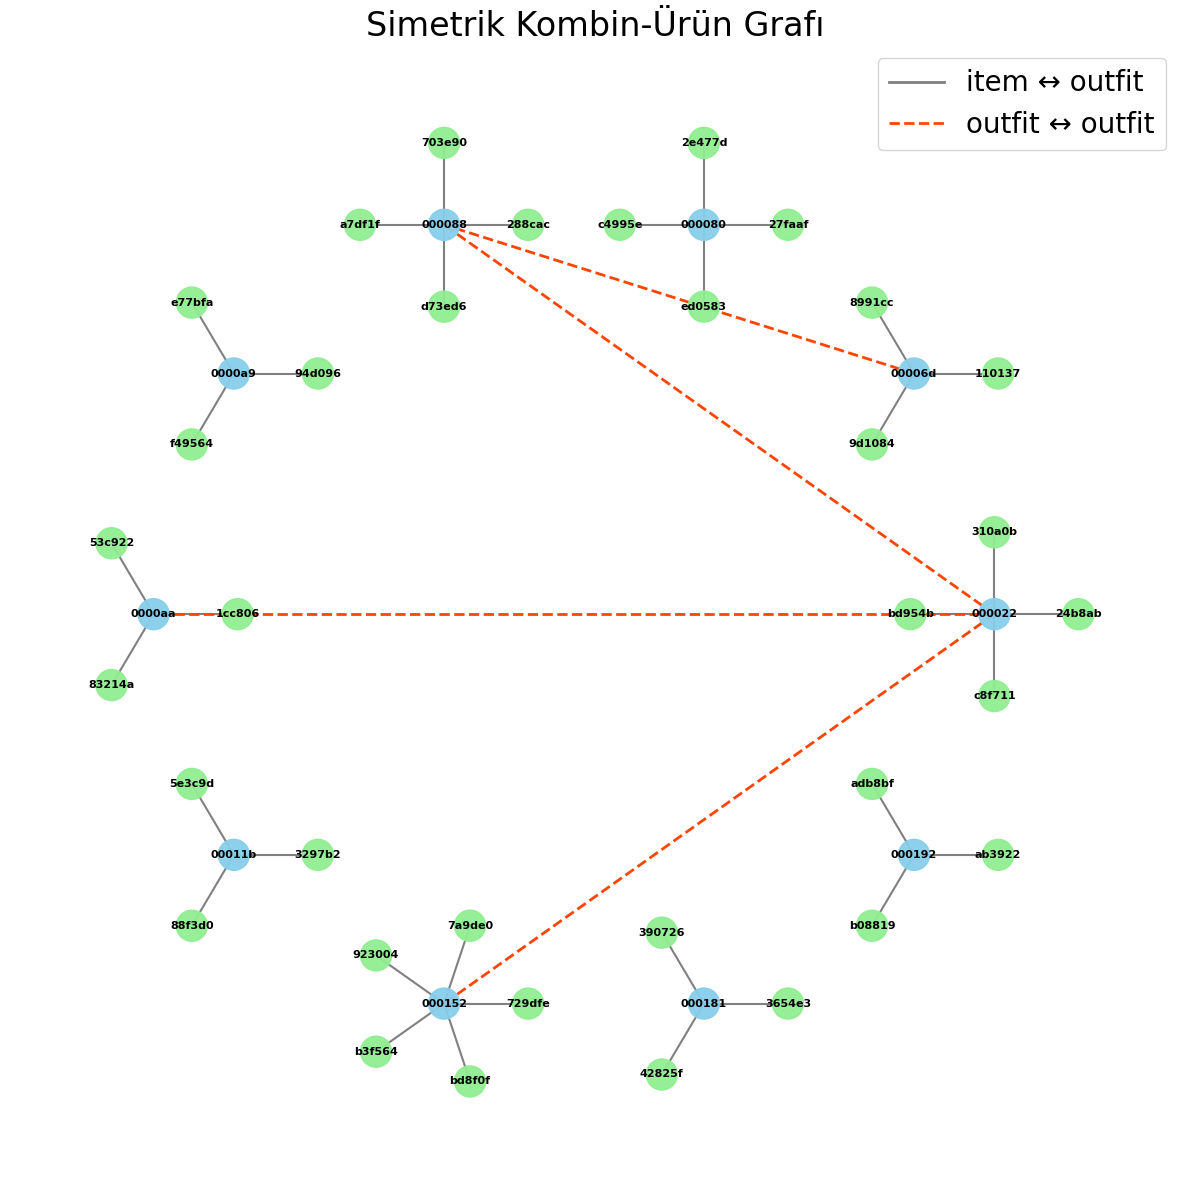

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.lines import Line2D

outfit_edges = []
for u in sample_outfits:
    for v in sample_outfits:
        if u >= v:
            continue
        if G.has_edge(u, v) and "sim" in G[u][v]:
            outfit_edges.append((u, v))

pos = {}
circle_pos = nx.circular_layout(sample_outfits)

for outfit in sample_outfits:
    pos[outfit] = circle_pos[outfit]
    neighbors = [n for n in subgraph.neighbors(outfit) if subgraph.nodes[n]["type"] == "item"]
    angle = 0
    radius = 0.2
    for i, item in enumerate(neighbors):
        offset_x = radius * np.cos(angle)
        offset_y = radius * np.sin(angle)
        pos[item] = pos[outfit] + np.array([offset_x, offset_y])
        angle += 2 * np.pi / max(1, len(neighbors))

node_colors = []
labels = {}
for node in subgraph.nodes(data=True):
    n_id, attr = node
    node_colors.append("skyblue" if attr["type"] == "outfit" else "lightgreen")
    labels[n_id] = n_id[:6]

item_edges = [(u, v) for u, v in subgraph.edges() if (u in sample_outfits and G.nodes[v]["type"] == "item") or (v in sample_outfits and G.nodes[u]["type"] == "item")]

plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(subgraph, pos, edgelist=item_edges, edge_color='gray', width=1.5)
nx.draw_networkx_edges(subgraph, pos, edgelist=outfit_edges, edge_color='orangered', width=2, style='dashed')
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=500, alpha=0.95)
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8, font_weight='bold')

legend_elements = [
    Line2D([0], [0], color='gray', lw=2, label='item ↔ outfit'),
    Line2D([0], [0], color='orangered', lw=2, linestyle='--', label='outfit ↔ outfit')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=20)

plt.title("Simetrik Kombin-Ürün Grafı", fontsize=24)
plt.axis("off")
plt.tight_layout()
plt.show()


### 6. Loading Pre-Extracted Feature Vectors

In this section, the feature vectors previously extracted from all outfit items using the ResNet50 model are loaded from the `item_features.npy` file.

This file contains a dictionary where:
- **Keys** are item image IDs (e.g., "a7f12e"),
- **Values** are 2048-dimensional vectors representing the visual features of each image.

These vectors will later be used to:
- Calculate similarity between a newly uploaded image and known items,
- Recommend the most compatible outfits based on cosine similarity.


In [7]:
feature_path = "item_features.npy"
features_dict = np.load(feature_path, allow_pickle=True).item()


### 7. Image Feature Extraction and Outfit Grid Visualization

This cell defines two utility functions:

- `extract_vector(image_path)`  
  Extracts a 2048-dimensional feature vector from a given clothing image using the pre-trained ResNet50 model.

- `show_outfit_grids(outfit_ids, base_folder, images_per_row=5)`  
  Displays each outfit's items as an image grid. Items are grouped by outfit ID, arranged in subplots, and labeled with truncated file names.


In [17]:
def extract_vector(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        vec = model(tensor).squeeze().numpy()
    return vec

def show_outfit_grids(outfit_ids, base_folder, images_per_row=5):
    for outfit_id in outfit_ids:
        outfit_path = os.path.join(base_folder, outfit_id)
        item_images = [
            os.path.join(outfit_path, img)
            for img in os.listdir(outfit_path)
            if img.endswith(".jpg")
        ]

        num_images = len(item_images)
        cols = min(images_per_row, num_images)
        rows = (num_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        fig.suptitle(f"Kombin: {outfit_id}", fontsize=18)

        if rows == 1:
            axes = [axes] if cols == 1 else axes
        elif cols == 1:
            axes = [[ax] for ax in axes]
        else:
            axes = axes.reshape(rows, cols)

        for i in range(rows * cols):
            row, col = divmod(i, cols)
            ax = axes[row][col] if rows > 1 else axes[col]

            if i < num_images:
                img = Image.open(item_images[i])
                ax.imshow(img)
                ax.set_title(os.path.basename(item_images[i])[:6], fontsize=18)
            ax.axis("off")

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()


### 8. Visualizing the Uploaded Item and Its Top Similar Items

This function displays the uploaded clothing image side-by-side with its top-N most visually similar items from the dataset.

- The input image is placed at the first position.
- Each similar item is retrieved by searching its corresponding outfit folder in the dataset.
- Items are labeled with truncated item IDs and cosine similarity scores.

This layout helps users visually compare the uploaded item with potential outfit matches.


In [20]:
def show_input_and_similar_items(new_image_path, similar_items, image_base_path):
    import matplotlib.pyplot as plt
    from PIL import Image

    num_similar = len(similar_items)
    total = num_similar + 1

    fig, axes = plt.subplots(1, total, figsize=(2.5 * total, 4))
    fig.suptitle("Yeni Ürün ve En Benzer Ürünler", fontsize=24)

    new_img = Image.open(new_image_path).convert("RGB")
    axes[0].imshow(new_img)
    axes[0].set_title("Yeni Ürün", fontsize=18)
    axes[0].axis("off")

    for i, (item_id, sim_score) in enumerate(similar_items, 1):
        found = False
        for neighbor in G.neighbors(item_id):
            if G.nodes[neighbor]["type"] == "outfit":
                item_path = os.path.join(image_base_path, neighbor, f"{item_id}.jpg")
                if os.path.exists(item_path):
                    found = True
                    break
        if not found:
            axes[i].axis("off")
            continue

        img = Image.open(item_path).convert("RGB")
        axes[i].imshow(img)
        axes[i].set_title(f"{item_id[:6]}\nsim: {sim_score:.2f}", fontsize=18)
        axes[i].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.82)
    plt.show()


### 9. Real-Time Outfit Recommendation and Visual Comparison

This section defines a function that:
- Extracts the feature vector of a newly uploaded image.
- Computes cosine similarities between this image and all items in the dataset.
- Selects the top-N most similar items and determines the most related outfits based on those items.

Finally, the uploaded item and its visually closest items are displayed side-by-side.

Parameters:
- `top_k_items`: Number of most similar items to consider.
- `top_k_outfits`: Number of outfits to return based on aggregate similarity scores.


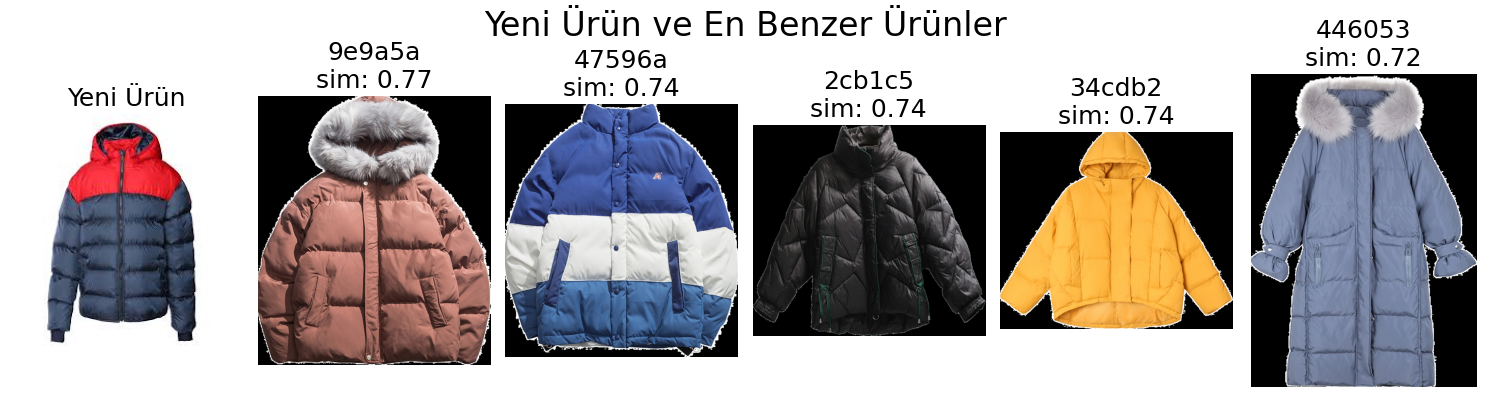

In [21]:
from collections import defaultdict
def recommend_outfits_return_similars(new_image_path, G, features_dict, top_k_items=5, top_k_outfits=3):
    new_vec = extract_vector(new_image_path)

    similarities = []
    for item_id, vec in features_dict.items():
        sim = cosine_similarity([new_vec], [vec])[0][0]
        similarities.append((item_id, sim))

    similarities.sort(key=lambda x: x[1], reverse=True)
    top_items = similarities[:top_k_items]

    outfit_scores = defaultdict(float)
    for item_id, sim in top_items:
        for neighbor in G.neighbors(item_id):
            if G.nodes[neighbor]["type"] == "outfit":
                outfit_scores[neighbor] += sim

    ranked_outfits = sorted(outfit_scores.items(), key=lambda x: x[1], reverse=True)
    return top_items, [outfit for outfit, _ in ranked_outfits[:top_k_outfits]]

new_image = r"C:\Users\semer\Desktop\indir1.jpg"
similar_items, suggested_outfits = recommend_outfits_return_similars(new_image, G, features_dict)
show_input_and_similar_items(new_image, similar_items, r"C:\Users\semer\Desktop\Resimler1")


### 10. Visualizing the Replacement of an Item in the Most Compatible Outfit

This section displays a side-by-side comparison of:
- The **original outfit**, which includes the item most visually similar to the new upload.
- The **updated outfit**, where the most similar item is replaced by the newly uploaded clothing image.

This approach illustrates the system’s dynamic recommendation ability and highlights how new items are integrated into existing outfit combinations based on visual compatibility.


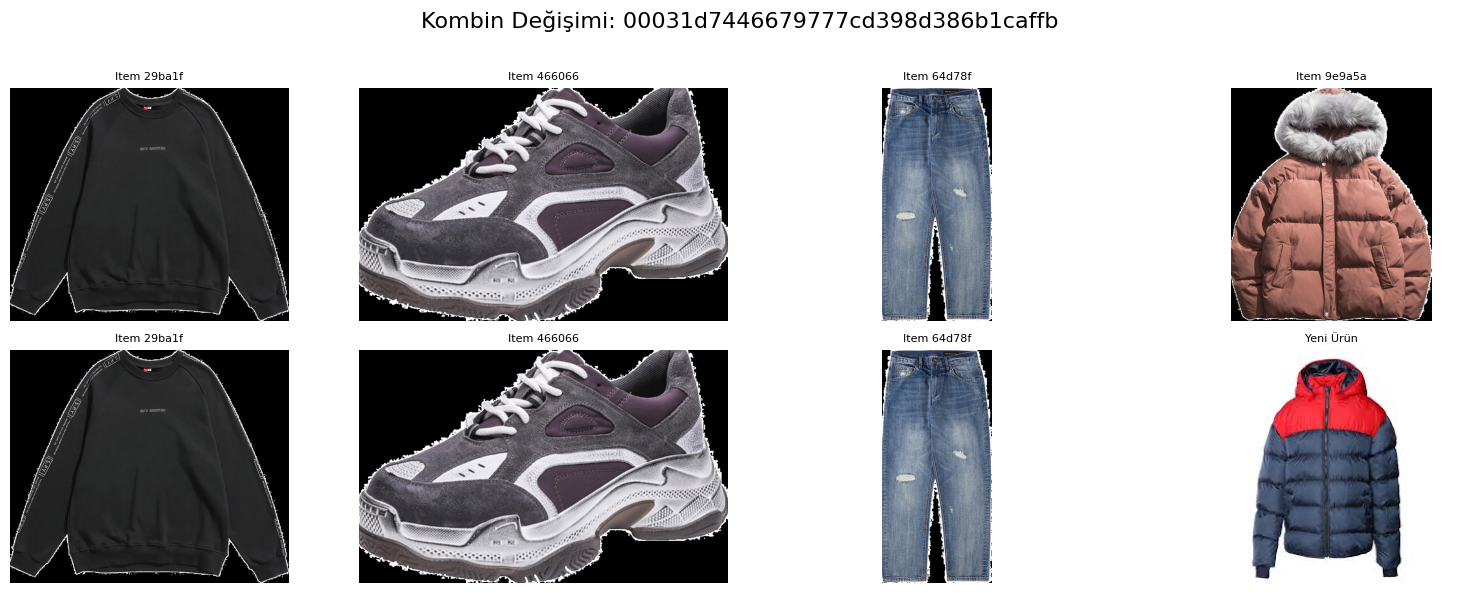

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_original_and_new_combination(new_image_path, target_outfit_id, similar_items, base_folder):
    outfit_path = os.path.join(base_folder, target_outfit_id)
    original_items = [
        os.path.join(outfit_path, img)
        for img in os.listdir(outfit_path)
        if img.endswith(".jpg")
    ]

    if not original_items:
        print(f"Kombin ({target_outfit_id}) klasöründe item bulunamadı.")
        return

    most_similar_item_id, _ = similar_items[0]

    replaced_item_path = None
    for img_path in original_items:
        if most_similar_item_id in img_path:
            replaced_item_path = img_path
            break

    if not replaced_item_path:
        print(f"{most_similar_item_id} kombin içinde bulunamadı, değiştirme yapılamadı.")
        return

    new_combination = [img for img in original_items if img != replaced_item_path]
    new_combination.append(new_image_path)

    fig, axes = plt.subplots(2, max(len(original_items), len(new_combination)), figsize=(16, 6))
    fig.suptitle(f"Kombin Değişimi: {target_outfit_id}", fontsize=16)

    for idx, img_path in enumerate(original_items):
        img = Image.open(img_path).convert("RGB")
        axes[0, idx].imshow(img)
        title = os.path.basename(img_path)[:6]
        axes[0, idx].set_title(f"Item {title}", fontsize=8)
        axes[0, idx].axis("off")

    for idx in range(len(original_items), max(len(original_items), len(new_combination))):
        axes[0, idx].axis("off")

    for idx, img_path in enumerate(new_combination):
        img = Image.open(img_path).convert("RGB")
        axes[1, idx].imshow(img)
        if idx == len(new_combination) - 1:
            axes[1, idx].set_title("Yeni Ürün", fontsize=8)
        else:
            title = os.path.basename(img_path)[:6]
            axes[1, idx].set_title(f"Item {title}", fontsize=8)
        axes[1, idx].axis("off")

    for idx in range(len(new_combination), max(len(original_items), len(new_combination))):
        axes[1, idx].axis("off")

    axes[0, 0].set_ylabel("Orijinal Kombin", fontsize=10)
    axes[1, 0].set_ylabel("Yeni Kombin", fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

new_image = r"C:\Users\semer\Desktop\indir1.jpg"
similar_items, suggested_outfits = recommend_outfits_return_similars(new_image, G, features_dict)
target_outfit = suggested_outfits[0]
show_original_and_new_combination(new_image, target_outfit, similar_items, r"C:\Users\semer\Desktop\Resimler1")


### 11. Displaying the Updated Outfit with Similarity Score

This function replaces the most visually similar item in the most compatible outfit with the newly uploaded item and visualizes the change.  

Additionally, it calculates a **new combination score** by computing the mean cosine similarity of all items to the outfit's center vector, providing a numerical measure of visual coherence.  

The updated outfit is displayed alongside the original, highlighting how the system adapts the combinations based on new inputs.


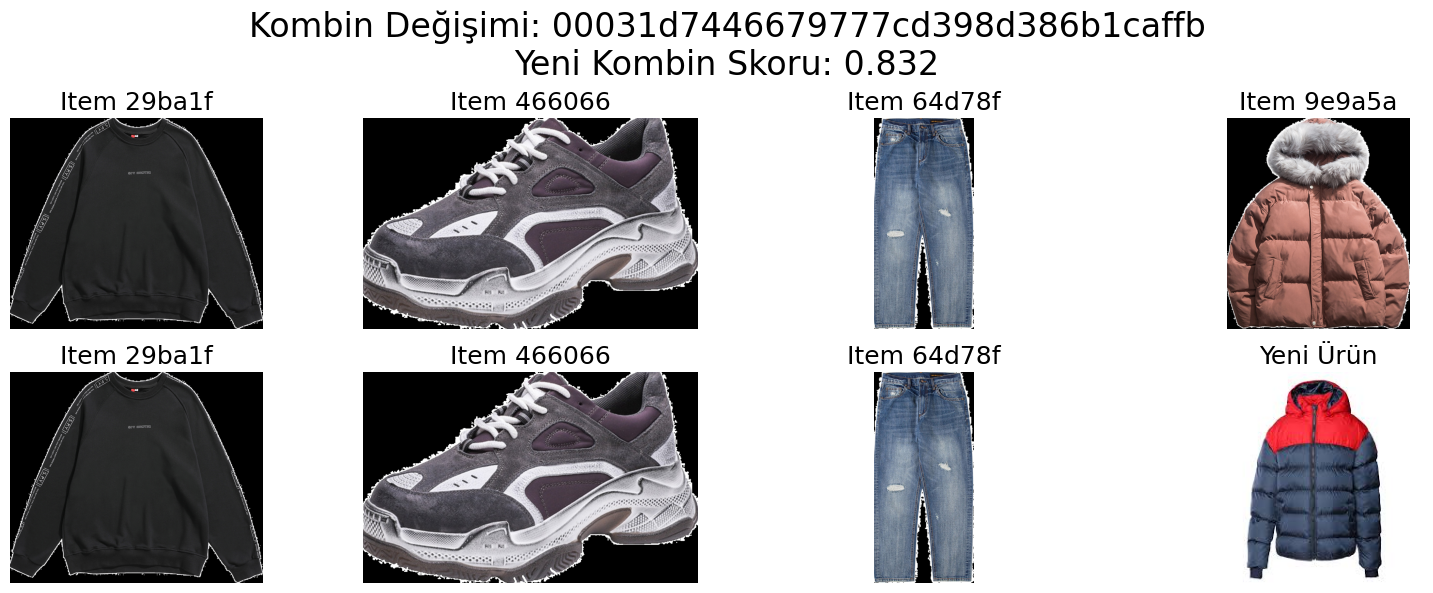

In [23]:
def show_original_and_new_combination_with_score(new_image_path, target_outfit_id, similar_items, base_folder, features_dict):
    outfit_path = os.path.join(base_folder, target_outfit_id)
    original_items = [
        os.path.join(outfit_path, img)
        for img in os.listdir(outfit_path)
        if img.endswith(".jpg")
    ]

    if not original_items:
        print(f"Kombin ({target_outfit_id}) klasöründe item bulunamadı.")
        return

    most_similar_item_id, _ = similar_items[0]

    replaced_item_path = None
    for img_path in original_items:
        if most_similar_item_id in img_path:
            replaced_item_path = img_path
            break

    if not replaced_item_path:
        print(f"{most_similar_item_id} kombin içinde bulunamadı, değiştirme yapılamadı.")
        return

    new_combination = [img for img in original_items if img != replaced_item_path]
    new_combination.append(new_image_path)

    new_features = []
    for img_path in new_combination:
        if img_path == new_image_path:
            new_vec = extract_vector(new_image_path)
            new_features.append(new_vec)
        else:
            item_id = os.path.basename(img_path).split(".")[0]
            if item_id in features_dict:
                new_features.append(features_dict[item_id])

    if len(new_features) > 1:
        center = np.mean(new_features, axis=0)
        similarities = cosine_similarity(new_features, [center]).flatten()
        new_comb_score = np.mean(similarities)
    else:
        new_comb_score = 0

    fig, axes = plt.subplots(2, max(len(original_items), len(new_combination)), figsize=(16, 6))
    fig.suptitle(f"Kombin Değişimi: {target_outfit_id}\nYeni Kombin Skoru: {new_comb_score:.3f}", fontsize=24)

    for idx, img_path in enumerate(original_items):
        img = Image.open(img_path).convert("RGB")
        axes[0, idx].imshow(img)
        title = os.path.basename(img_path)[:6]
        axes[0, idx].set_title(f"Item {title}", fontsize=18)
        axes[0, idx].axis("off")

    for idx in range(len(original_items), max(len(original_items), len(new_combination))):
        axes[0, idx].axis("off")

    for idx, img_path in enumerate(new_combination):
        img = Image.open(img_path).convert("RGB")
        axes[1, idx].imshow(img)
        if idx == len(new_combination) - 1:
            axes[1, idx].set_title("Yeni Ürün", fontsize=18)
        else:
            title = os.path.basename(img_path)[:6]
            axes[1, idx].set_title(f"Item {title}", fontsize=18)
        axes[1, idx].axis("off")

    for idx in range(len(new_combination), max(len(original_items), len(new_combination))):
        axes[1, idx].axis("off")

    axes[0, 0].set_ylabel("Orijinal Kombin", fontsize=18)
    axes[1, 0].set_ylabel("Yeni Kombin", fontsize=18)

    plt.tight_layout()
    plt.subplots_adjust(top=0.80)
    plt.show()


new_image = r"C:\Users\semer\Desktop\indir1.jpg"
similar_items, suggested_outfits = recommend_outfits_return_similars(new_image, G, features_dict)
target_outfit = suggested_outfits[0]

show_original_and_new_combination_with_score(
    new_image,
    target_outfit,
    similar_items,
    r"C:\Users\semer\Desktop\Resimler1",
    features_dict
)


In [13]:
import networkx as nx
import pickle

with open("outfit_graph.gpickle", "wb") as f:
    pickle.dump(G, f)

print("✅ Graph başarıyla 'outfit_graph.gpickle' olarak kaydedildi.")


✅ Graph başarıyla 'outfit_graph.gpickle' olarak kaydedildi.
